---
# Create MOM6 LGM tidal energy file
- Author: Jiang Zhu (jiangzhu@ucar.edu)
- Tools used
  - [xesmf](https://github.com/pangeo-data/xESMF)
  - [pop_tools](https://pop-tools.readthedocs.io/en/latest/)
- References
  - [MOM6 Manual](https://mom6.readthedocs.io/en/main/api/generated/pages/Internal_Vert_Mixing.html?highlight=tidal#internal-vert-mixing-1section-internal-tidal-mixing)
  - [Wilmes et al. (2019)]( https://doi.org/10.1029/2019PA003644)
---

In [1]:
import subprocess
import datetime
import copy

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import xesmf
import pop_tools

import warnings
warnings.filterwarnings('ignore')

---
## Examine the high-res. tidal model results from [Wilmes et al. (2019)](https://doi.org/10.1029/2019PA003644)
- Data downloaded from [zenodo](https://zenodo.org/records/1139242)

In [2]:
tide_cases = {}

data_dir = '/glade/campaign/cesm/development/palwg/raw_boundary_data/lgm_tidal'

tide_cases['wilmes_pi'] = {
    'data_dir': data_dir,
    'fname': 'diss_dir_js_1_8_rtop_00kyrBP_-I6.0_7672998.nc'}

tide_cases['wilmes_21ka_i6g'] = {
    'data_dir': data_dir,
    'fname': 'diss_dir_js_1_8_rtop_21kyrBP_i6g_-t_-I6.0_7673000.nc'}

tide_cases['wilmes_21ka_i5g'] = {
    'data_dir': data_dir,
    'fname': 'diss_dir_js_1_8_rtop_21kyrBP_i5g_-t_-I6.0_7672999.nc'}

### Compute the global integration

In [3]:
for key in tide_cases.keys():

    tide_file = f"{tide_cases[key]['data_dir']}/{tide_cases[key]['fname']}"
    ds = xr.open_dataset(tide_file).rename(
        {'LATITUDE': 'lat', 'LONGITUDE': 'lon'}).squeeze()

    lat = np.deg2rad(ds.lat.values)
    lon = np.deg2rad(ds.lon.values)
    d_lat = np.diff(lat)[0]
    d_lon = np.diff(lon)[0]
    R = 6371000.0
    area = np.cos(lat) * (R ** 2) * d_lat * d_lon

    ds.diss.data = xr.where(ds.mz == 1, ds.diss, np.nan)

    diss_x_A = ds.diss * area / 1e12

    diss_ttl = diss_x_A.sum(dim=['lat', 'lon'])
    print(f"{key} total diss: {diss_ttl:3.2f} TW")

    # diss_ttl2 = ((ds.EDM2 + ds.EDS2 + ds.EDK1 + ds.EDO1) * area).sum(
    #     dim=['lat', 'lon']).values / 1e12
    # print(f"{key} total diss (M2+S2+K1+O1): {diss_ttl2:3.2f} TW")

    diss_ttl_deep = diss_x_A.where(ds.hz > 500).sum(dim=['lat', 'lon'])
    print(f"{key} deep diss (z > 500 m): {diss_ttl_deep:3.2f} TW")

    ds['diss_ttl'] = diss_ttl
    ds['diss_ttl_deep'] = diss_ttl_deep
    tide_cases[key]['ds'] = ds

wilmes_pi total diss: 1.20 TW
wilmes_pi deep diss (z > 500 m): 0.92 TW
wilmes_21ka_i6g total diss: 2.42 TW
wilmes_21ka_i6g deep diss (z > 500 m): 1.83 TW
wilmes_21ka_i5g total diss: 3.54 TW
wilmes_21ka_i5g deep diss (z > 500 m): 2.86 TW


In [4]:
tide_cases['wilmes_pi']['ds']

<xarray.Dataset> Size: 265MB
Dimensions:        (lat: 1440, lon: 2880)
Coordinates:
  * lat            (lat) float64 12kB -89.94 -89.81 -89.69 ... 89.69 89.81 89.94
  * lon            (lon) float64 23kB 0.0625 0.1875 0.3125 ... 359.7 359.8 359.9
Data variables: (12/15)
    ddeep_tot      float32 4B ...
    ddeep_m2       float32 4B ...
    ddeep_s2       float32 4B ...
    ddeep_k1       float32 4B ...
    ddeep_o1       float32 4B ...
    diss           (lon, lat) float64 33MB nan nan nan nan ... nan nan nan nan
    ...             ...
    EDO1           (lon, lat) float64 33MB ...
    mz             (lon, lat) float64 33MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    hz             (lon, lat) float64 33MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    lala           (lon, lat) float64 33MB ...
    diss_ttl       float64 8B 1.203
    diss_ttl_deep  float64 8B 0.9165

### Make plot

In [5]:
vmin = 1e-8
vmax = 1
levels = np.logspace(np.log10(vmin), np.log10(vmax), 9)

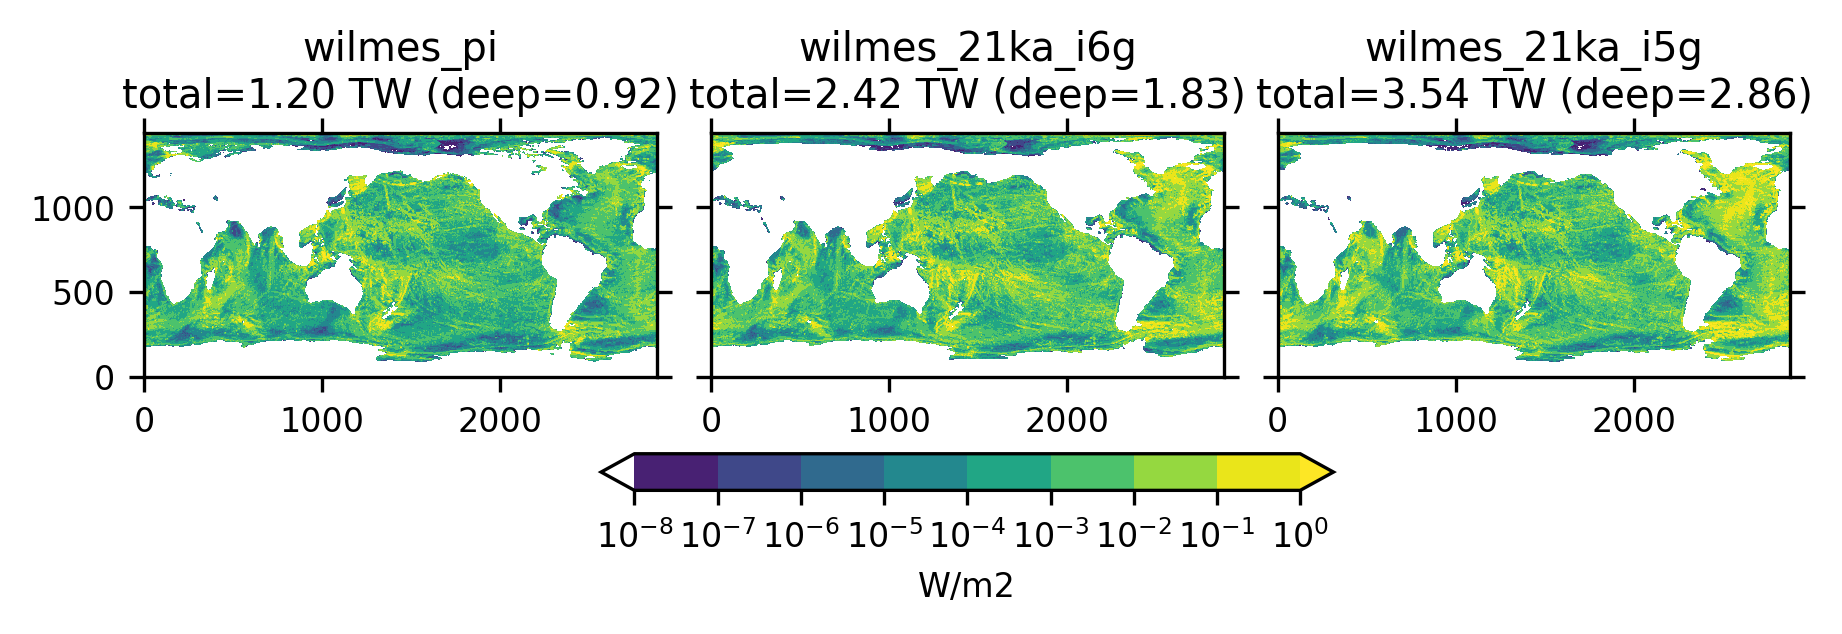

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(6, 2),
                         sharex=True, sharey=True,
                         constrained_layout=True)

for ax, key in zip(axes.ravel(), tide_cases.keys()):

    ds = tide_cases[key]['ds']

    hc = ax.contourf(ds.diss.T, levels=levels, extend='both')
    hc.set_norm(mcolors.LogNorm(vmin=vmin, vmax=vmax))

    title = f"{key}\ntotal={ds.diss_ttl:3.2f} TW (deep={ds.diss_ttl_deep:3.2f})"
    ax.set_title(title)

cb = fig.colorbar(hc, ax=axes, orientation='horizontal', shrink=0.5)
cb.set_label('W/m2')

- NOTE: Somehow, Wilmes PI has an LGM-like land-sea mask

---
## Examine the POP and MOM PI files (derived from Steven Jayne's data)

### Read POP2 file and compute global integration
- Use pop_tools to get the gx1v6 grid 

In [7]:
ds_pop_pre = pop_tools.get_grid('POP_gx1v6')[['KMT', 'TAREA', 'z_t']]
nlat = len(ds_pop_pre.nlat)
nlon = len(ds_pop_pre.nlon)
print(ds_pop_pre.z_t[32].values/100)

data_tmp = np.fromfile(
    '/glade/campaign/cesm/cesmdata/inputdata/ocn/pop/gx1v6/forcing/tidal_energy_gx1v6_20090205.ieeer8',
    dtype='>f8', count=nlat*nlon
)
data_tmp = np.reshape(data_tmp, [nlon, nlat], order='F').T

ds_pop_pre['diss'] = ds_pop_pre.TAREA * 0 + data_tmp

482.7367289999999


In [8]:
diss_x_A = ds_pop_pre.diss * ds_pop_pre.TAREA / 1e16
ds_pop_pre['diss_ttl'] = diss_x_A.where(ds_pop_pre.KMT > 0).sum()
ds_pop_pre['diss_ttl_deep'] = diss_x_A.where(ds_pop_pre.KMT > 33).sum()

ds_pop_pre

<xarray.Dataset> Size: 2MB
Dimensions:        (nlat: 384, nlon: 320, z_t: 60)
Coordinates:
  * z_t            (z_t) float64 480B 500.0 1.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    KMT            (nlat, nlon) int32 492kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    TAREA          (nlat, nlon) float64 983kB 1.125e+13 1.125e+13 ... 7.432e+12
    diss           (nlat, nlon) float64 983kB -1e+34 -1e+34 ... -1e+34 -1e+34
    diss_ttl       float64 8B 1.924
    diss_ttl_deep  float64 8B 1.553
Attributes:
    lateral_dims:       [384, 320]
    vertical_dims:      60
    vert_grid_file:     gx1v7_vert_grid
    horiz_grid_fname:   inputdata/ocn/pop/gx1v6/grid/horiz_grid_20010402.ieeer8
    topography_fname:   inputdata/ocn/pop/gx1v6/grid/topography_20090204.ieeei4
    region_mask_fname:  inputdata/ocn/pop/gx1v6/grid/region_mask_20090205.ieeei4
    type:               dipole
    title:              POP_gx1v6 grid

### Read the MOM6 file and compute global integration
- Use MOM geometry file to get the area and depth

In [9]:
ds_mom_pre = xr.open_dataset(
    '/glade/campaign/cesm/cesmdata/inputdata/ocn/mom/tx2_3v2/energy_new_tx2_3_conserve_230415_cdf5.nc')

ds_mom_geom = xr.open_dataset('/glade/campaign/cesm/cesmdata/inputdata/ocn/mom/tx2_3v2/ocean_geometry.nc')

In [10]:
diss_x_A = ds_mom_pre.wave_dissipation * ds_mom_geom.Ah.values / 1e12
ds_mom_pre['diss_ttl'] = diss_x_A.where(ds_mom_geom.D.values > 0).sum()
ds_mom_pre['diss_ttl_deep'] = diss_x_A.where(ds_mom_geom.D.values > 500).sum()

ds_mom_pre

<xarray.Dataset> Size: 6MB
Dimensions:           (ny: 480, nx: 540)
Coordinates:
    lon               (ny, nx) float64 2MB ...
    lat               (ny, nx) float64 2MB ...
Dimensions without coordinates: ny, nx
Data variables:
    wave_dissipation  (ny, nx) float64 2MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    diss_ttl          float64 8B 1.916
    diss_ttl_deep     float64 8B 1.482
Attributes:
    description:  Estimated tidal dissipation data by S.R. Jayne. WHOI.
    author:       Alper Altuntas (altuntas@ucar.edu)
    created:      2023-16-04 14:52:43

### Make plot

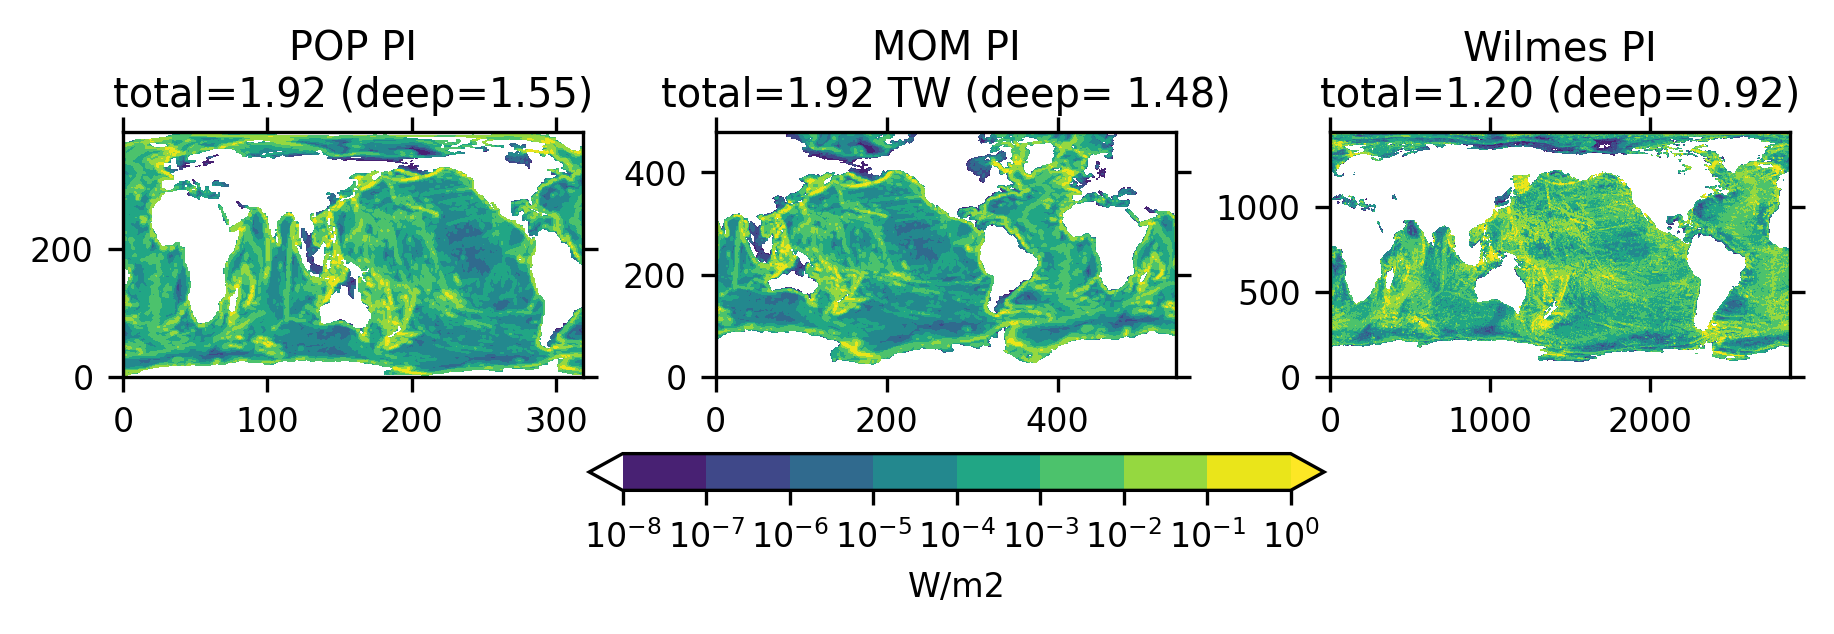

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(6, 2),
                         sharex=False, sharey=False,
                         constrained_layout=True)

ax = axes[0]
hc = ax.contourf(ds_pop_pre.diss, levels=levels, extend='both')
hc.set_norm(mcolors.LogNorm(vmin=vmin, vmax=vmax))
ax.set_title(f"POP PI\ntotal={ds_pop_pre.diss_ttl:3.2f} (deep={ds_pop_pre.diss_ttl_deep:3.2f})")

ax = axes[1]
hc = ax.contourf(ds_mom_pre.wave_dissipation, levels=levels, extend='both')
hc.set_norm(mcolors.LogNorm(vmin=vmin, vmax=vmax))
ax.set_title(f"MOM PI\ntotal={ds_mom_pre.diss_ttl:3.2f} TW (deep={ds_mom_pre.diss_ttl_deep: 3.2f})")

ax = axes[2]
ds = tide_cases['wilmes_pi']['ds']
hc = ax.contourf(ds.diss.T, levels=levels, extend='both')
hc.set_norm(mcolors.LogNorm(vmin=vmin, vmax=vmax))
ax.set_title(f"Wilmes PI\ntotal={ds.diss_ttl:3.2f} (deep={ds.diss_ttl_deep:3.2f})")

cb = fig.colorbar(hc, ax=axes, orientation='horizontal', shrink=0.5,)
cb.set_label('W/m2')

- Q1: Is the PI energy flux from Jayne 2009 (?) in POP2/MOM6 too large?
  - Wilmes et al's tide model shows 1.2 TW, consistent with [other numbers](https://doi.org/10.1038/s43017-020-0097-z).
  - Wilmes PI has an LGM-like land-sea mask. Is it related?
- Q2: How do I set up CESM3 LGM if I don't want to create a new piControl with the Wilmes PI tide?
  - Use Wilmes I6G `diss` and scale it by PI_Jayne_ttl / PI_Wilmes_ttl 

---
## Use Wilmes I6G `diss` and scale it by PI_Jayne_ttl / PI_Wilmes_ttl 

In [12]:
scale_factor = ds_mom_pre.diss_ttl / tide_cases['wilmes_pi']['ds'].diss_ttl
print(f"scale factor = {scale_factor:3.2f}")

scale factor = 1.59


### Regrid wilmes variable into MOM grid
- https://pangeo-xesmf.readthedocs.io/en/latest/notebooks/Masking.html

<xarray.Dataset> Size: 100MB
Dimensions:  (lat: 1440, lon: 2880, lon_b: 2881, lat_b: 1441)
Coordinates:
  * lat      (lat) float64 12kB -89.94 -89.81 -89.69 ... 89.69 89.81 89.94
  * lon      (lon) float64 23kB 0.0625 0.1875 0.3125 ... 359.7 359.8 359.9
  * lon_b    (lon_b) float64 23kB 0.0 0.125 0.25 0.375 ... 359.8 359.9 360.0
  * lat_b    (lat_b) float64 12kB -90.0 -89.88 -89.75 ... 89.75 89.88 90.0
Data variables:
    diss     (lon, lat) float64 33MB nan nan nan nan nan ... nan nan nan nan nan
    hz       (lon, lat) float64 33MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    mask     (lat, lon) int64 33MB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0

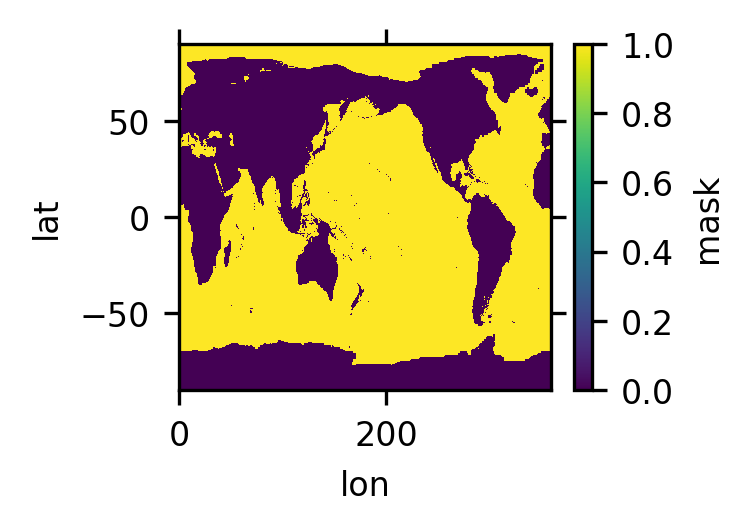

In [13]:
ds_wilmes_i6g = tide_cases['wilmes_21ka_i6g']['ds'][['lat', 'lon', 'diss', 'hz']]
ds_wilmes_i6g['mask'] = xr.where(ds_wilmes_i6g.hz > 0, 1, 0).T
ds_wilmes_i6g.mask.plot(size=1.5)
ds_wilmes_i6g['lon_b'] = np.linspace(0, 360, 2881)
ds_wilmes_i6g['lat_b'] = np.linspace(-90, 90, 1441)

ds_wilmes_i6g

<xarray.Dataset> Size: 6MB
Dimensions:  (ny: 480, nx: 540, lon: 540, lat: 480, lon_b: 541, lat_b: 481)
Coordinates:
  * lon      (lon) float64 4kB -286.7 -286.0 -285.3 -284.7 ... 71.33 72.0 72.67
  * lat      (lat) float64 4kB -81.56 -81.46 -81.36 -81.26 ... 89.33 89.6 89.86
  * lon_b    (lon_b) float64 4kB -287.0 -286.3 -285.7 ... 71.67 72.33 73.0
  * lat_b    (lat_b) float64 4kB -81.61 -81.51 -81.41 ... 89.46 89.72 89.91
Dimensions without coordinates: ny, nx
Data variables:
    y        (ny, nx) float64 2MB ...
    x        (ny, nx) float64 2MB ...
    mask     (ny, nx) int32 1MB ...
    depth    (ny, nx) float32 1MB ...
Attributes:
    date_created:  2025-01-08T14:23:32.689354
    title:         LGM bathymetry file for MOM6 by Jiang Zhu (jiangzhu@ucar.e...
    min_depth:     2.5
    max_depth:     8008.71923828125

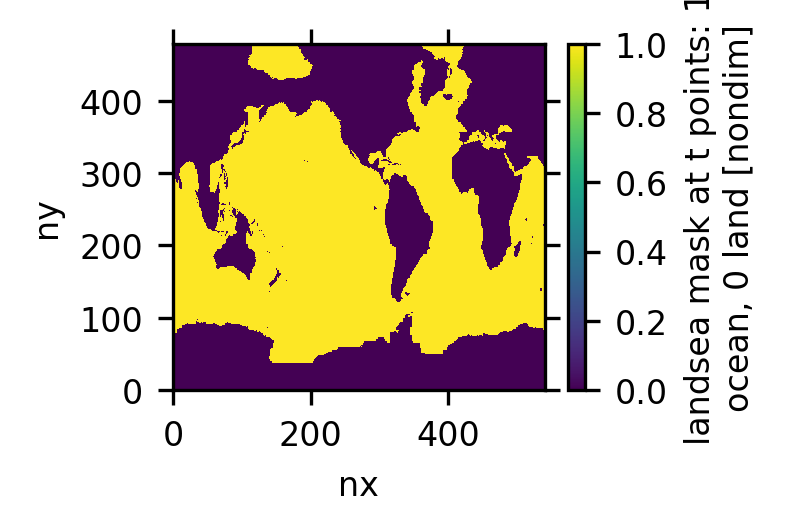

In [14]:
mom6_lgm = xr.open_dataset('/glade/work/jiangzhu/data/inputdata/mom/tx2_3v2/ocean_topo_tx2_3v2_240501_21ka_250108.nc')

mom6_grid = xr.open_dataset('/glade/campaign/cesm/cesmdata/inputdata/ocn/mom/tx2_3v2/ocean_topo_tx2_3v2_240501.nc')
mom6_grid = mom6_grid.rename({'lonh': 'lon', 'lath': 'lat',
                              'lonq': 'lon_b', 'latq': 'lat_b'})

mom6_lgm['lon'] = mom6_grid.lon
mom6_lgm['lat'] = mom6_grid.lat
mom6_lgm['lon_b'] = mom6_grid.lon_b  # Needed for conservative regridding
mom6_lgm['lat_b'] = mom6_grid.lat_b  # Needed for conservative regridding

mom6_lgm.mask.plot(size=1.5)
mom6_lgm

In [ ]:
%%time
 
regridder = xesmf.Regridder(
    ds_wilmes_i6g,
    mom6_lgm,
    method='conservative_normed',
    # method='conservative',
    # method='bilinear',
    # method='patch',
    # extrap_method="nearest_s2d",
    periodic=True)

diss_wilmes_i6g_mom = regridder(ds_wilmes_i6g['diss'] * scale_factor.values)

### Create the final scaled LGM file and compute global integration

In [ ]:
ds_mom_lgm = ds_mom_pre.copy(deep=True)

ds_mom_lgm.wave_dissipation.data = diss_wilmes_i6g_mom.data

diss_x_A = ds_mom_lgm.wave_dissipation * ds_mom_geom.Ah.values / 1e12
ds_mom_lgm['diss_ttl'] = diss_x_A.where(ds_mom_geom.D.values > 0.0).sum()
ds_mom_lgm['diss_ttl_deep'] = diss_x_A.where(ds_mom_geom.D.values > 500.0).sum()

ds_mom_lgm

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(5, 2.5),
                         sharex=True, sharey=True,
                         constrained_layout=True)

ax = axes[0]
hc = ax.contourf(ds_mom_pre.wave_dissipation, levels=levels, extend='both')
hc.set_norm(mcolors.LogNorm(vmin=vmin, vmax=vmax))
ax.set_title(f"MOM PI\ntotal={ds_mom_pre.diss_ttl:3.2f} (deep={ds_mom_pre.diss_ttl_deep: 3.2f})")

ax = axes[1]
hc = ax.contourf(ds_mom_lgm.wave_dissipation, levels=levels, extend='both')
hc.set_norm(mcolors.LogNorm(vmin=vmin, vmax=vmax))
ax.set_title(f"Wilmes LGM Scaled\ntotal={ds_mom_lgm.diss_ttl:3.2f} TW (deep={ds_mom_lgm.diss_ttl_deep:3.2f})")

cb = fig.colorbar(hc, ax=axes, orientation='horizontal', shrink=0.5,)
cb.set_label('W/m2')

### A summary of interpolation method
- The `conservative` method does not conserve total integral 100%, but with a small difference (3.92 - 3.85) / 3.85 = 1.8%

|          | total    | total_deep |
|----------|----------|----------|
| Wilmes   | 2.42     | 1.83     |
| Wilmes x 1.59| 3.85 | 2.91     |
| Bilinear | 3.77     | 3.32     |
| Bilinear_extrap | 4.23     | 3.73|
| conservative| 3.76   | 3.24   |
| conservativeNorm| 3.92 | 3.36 |
| patch    | 3.19  | 2.77  |


## Save netcdf

In [ ]:
today = datetime.date.today().strftime("%y%m%d")
print(today)

work_dir = '/glade/work/jiangzhu/data/inputdata/mom/tx2_3v2'
mom_lgm_tidal = f"{work_dir}/tidal_energy_tx2_3_21ka_{today}.nc"

del ds_mom_lgm.attrs['description']
del ds_mom_lgm.attrs['author']
del ds_mom_lgm.attrs['created']

ds_mom_lgm.attrs['Title'] = 'CESM3 LGM tidal energy file'
ds_mom_lgm.attrs['Author'] = 'Jiang Zhu (jiangzhu@ucar.edu)'
ds_mom_lgm.attrs['Source_files_from'] = 'Wilmes_et_al_2019'
ds_mom_lgm.attrs['Script'] = '06.create_mom6_lgm_tidal.ipynb'
ds_mom_lgm.attrs['More_info'] = 'https://github.com/NCAR/paleowg-recipes/cesm3'
ds_mom_lgm.attrs["Date_created"] = datetime.datetime.now().isoformat()

ds_mom_lgm.to_netcdf(mom_lgm_tidal, format="NETCDF3_64BIT")